# Private test not that **private** afterall 🙈


Having access to any information regarding the private test dataset is always useful. In this competition even more since [semi-supervised learning](https://www.kaggle.com/c/tweet-sentiment-extraction/discussion/143094) may play a decisive role.

After some Googling, I came across the (probably) initial dataset that has been used by the author of this (atypical) Kaggle challenge.

In this notebook, starting from the found dataset, I will attempt to create the **private test dataset** and will propose some ideas on how we can use this data to enhance our models.

**Clean data**

I believe that this is quite an important discovery, as the found dataset **has not been processed**. In the Exploratory Data Analysis part, we will see how salient information such as hashtags and uncensured words are present in that dataset. Also, and maybe even more important, all original 13 sentiments are still present (empty, sadness, enthusiasm, neutral, worry, surprise, love, fun, hate, happiness, boredom, relief, anger).

**💡Ideas**

Among others, one of the main advantages we can have by using this dataset is to find a subset of the training data that better match the private dataset set and try to *overfit* a model to that data.

Also, as we will see later, the extra informations such as hahtags, tweet authors and sentiment can be used during pre and post-processing, as they play an important role in this challenge.

**Data leakage**

As some of you correctly specified, we cannot says that this is _data leakage_ as the original dataset is mentioned in the challenge description: _The dataset is titled Sentiment Analysis: Emotion in Text tweets._ Nontheless, the link (https://www.figure-eight.com/data-for-everyone/) they refers to is broken.

The dataset is also available here in Kaggle: https://www.kaggle.com/icw123/emotion 

### Import ftfy and other libraries

In this notebook I will use `ftfy`. I just discovered this python package some days ago and I would say it's exceptional! If you, like me, do not know it, you can check it out there [@LuminosoInsight/python-ftfy](https://github.com/LuminosoInsight/python-ftfy).

Given any string, such as `Kaggle is a cool placee &lt;3`, `ftfy.fix_text()` almost magically returns:

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import re

tqdm.pandas()

import ftfy
ftfy.fix_text('Kaggle is a cool placee &lt;3')

'Kaggle is a cool placee <3'

# Original dataset and EDA

Disclaimer: even if I call this dataframe `original`, I do not assure that it's exactly the one that the Challenge's authors used. For consistency, I will use the name for the rest of the notebook and I will try to prove that we can extract a subset of "private train data", but clearly I cannot assure anything. 

The dataframe can be found at the [following github link](https://raw.githubusercontent.com/Galanopoulog/DATA607-Project-4/master/TextEmotion.csv). If you search for some of the `train_df` and `test_df` tweets, you will shortly find a correspondency.

Also, this [Github README](https://github.com/sarnthil/unify-emotion-datasets/tree/master/datasets) provides some additional information regarding the dataset. As we already know, it has been released by an AI company called _eightfigure_. The same README has an "official" download link from the _eightfigure_ website (http://www.crowdflower.com/wp-content/uploads/2016/07/text_emotion.csv) but the link is broken (for your reference: recently _eightfigure_ has been bought by another company and some links were lost)

In [2]:
original_df = pd.read_csv("https://raw.githubusercontent.com/Galanopoulog/DATA607-Project-4/master/TextEmotion.csv")
original_df.head()

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...


### Single tweet

Let's take at random a tweet from the TSE `train_df`: "sooo sad i will miss you here in san diego!!!" (with `textID` 549e992a42)

As we can see, the `original_df` contains the span text:

In [3]:
tweet = "sooo sad i will miss you here in san diego!!!"
original_df[original_df['content'].str.lower().str.contains(tweet)]

,tweet_id,sentiment,author,content
7591,1961767976,sadness,hidalgoal,@danecook Sooo SAD I will miss you here in San...


Even more interesting, we know who is the tweet `author`, hidalgoal, we have access to the hashtag, @danecook, and we have granular information information regarding the `sentiment`, sadness.

### Sentiment feature

In this dataset, there are **13** sentiments: 

In [4]:
len(original_df['sentiment'].unique())

13

In [5]:
list(original_df['sentiment'].unique())

['empty',
 'sadness',
 'enthusiasm',
 'neutral',
 'worry',
 'surprise',
 'love',
 'fun',
 'hate',
 'happiness',
 'boredom',
 'relief',
 'anger']

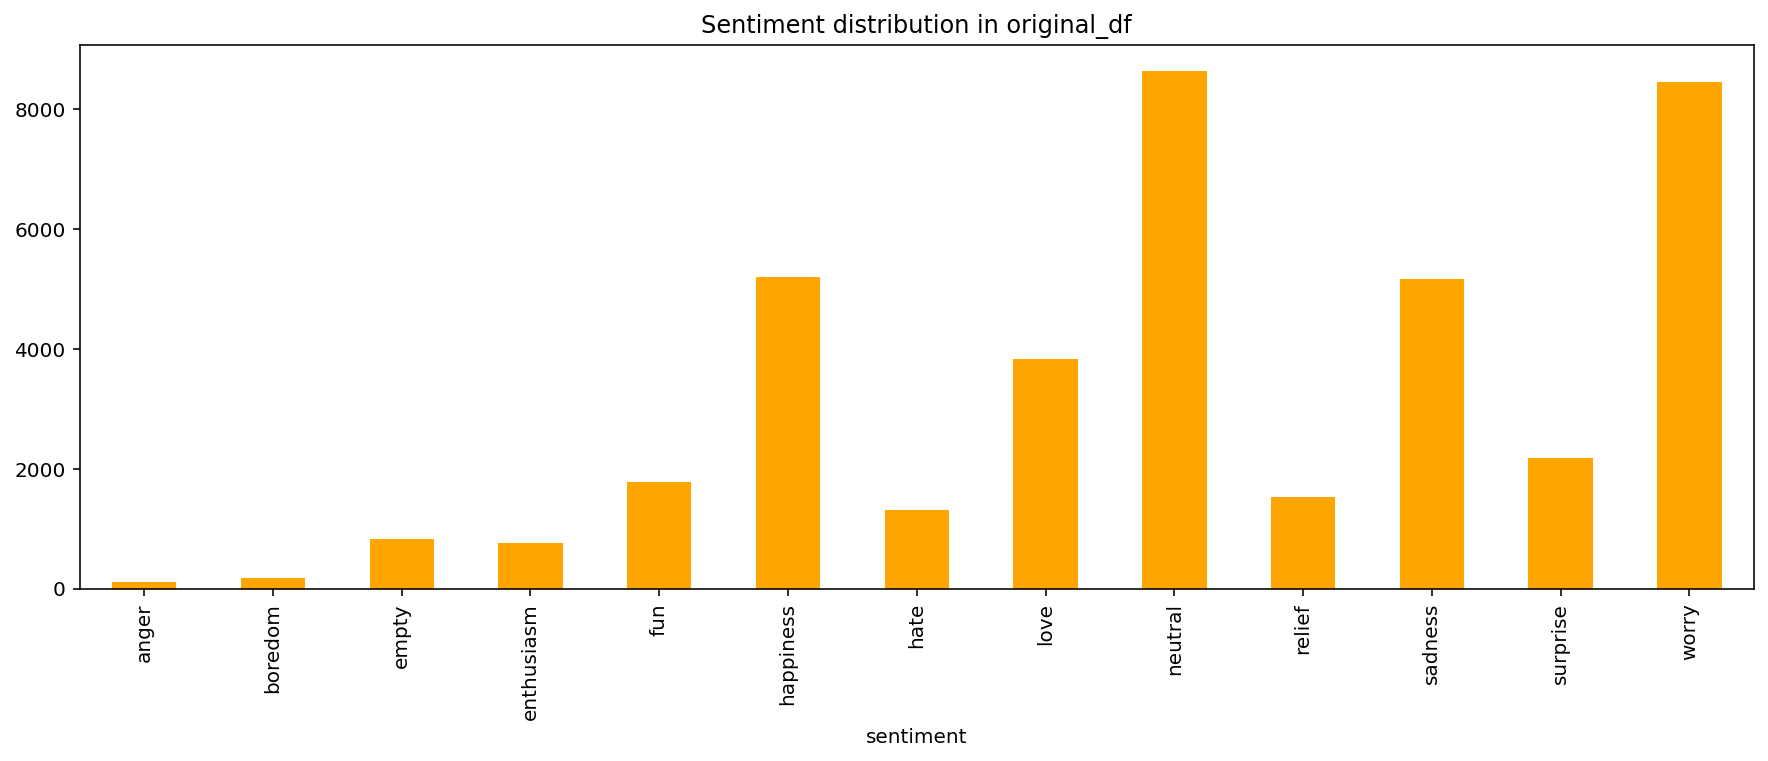

In [6]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5)

%config InlineBackend.figure_format='retina'

title = "Sentiment distribution in original_df"
original_df.groupby('sentiment')['content'].count().plot.bar(color='orange', title=title);

`happiness`, `neutral`, `sadness` and `worry` are the most used sentiment. We can assume that `happiness` was mapped to `positive`, whereas `sadness` and `worry` were mapped to `negative`.

**Key takeaways**

We can notice how the distribution between the sentiment is different. We may, for instance, discover that our model has difficulties to find the _support phrase_ for sentiment fewer commons, such as `boredom` or `relief`. In this case, we may want to do some pre-processing.

Also, in the official `train_df` the jaccard score for the `negative` sentiment is about 0.97. In the next versions, I will try to map each tweet to the more granular sentiment and will analyze the jaccard for each column.

### Tweet authors

Among 40k different tweets, there are 33871 different authors. This fact may also be exploited to increase the score. Note also that since the data have been randomly split into train/public test/private test, it may happens that tweets from the same authors **are present both in train and test datasets**. 

In [7]:
len(original_df['author'].unique())

33871

_MissxMarisa_ is the most active users with 23 tweets, followed by _ChineseLearn_, _erkagarcia_ and _MiDesfileNegro_.

In [8]:
original_df['author'].value_counts()

MissxMarisa       23
ChineseLearn      22
MiDesfileNegro    19
erkagarcia        19
lost_dog          18
                  ..
midilli            1
Caiteee            1
theeval            1
jaispot            1
negativeman        1
Name: author, Length: 33871, dtype: int64

# Construction of private test set

The `original_df` has exactly 40 thousand tweets, by simply subtracting the size of the train and test TSE datasets, we can find the private test dataset size. 

In [9]:
TSE_DATA = "/kaggle/input/tweet-sentiment-extraction/"

train_df = pd.read_csv(TSE_DATA + "train.csv").dropna().reset_index(drop=True)
test_df = pd.read_csv(TSE_DATA + "test.csv")

In [10]:
size_private_df = original_df.shape[0] - train_df.shape[0] - test_df.shape[0]
size_private_df

8986

[](http://)From the TSE leaderboard we discover that **leaderboard [..] approximately 30% of the test data. The final results will be based on the other 70%**. By a simple calculus, the expected size of the private leaderboard is 8246, 700 less than our estimation. Probably, this is due to the fact that some of the tweets were removed during the [Leaderboard update coming!](https://www.kaggle.com/c/tweet-sentiment-extraction/discussion/142073).

In [11]:
test_df.shape[0] / 30 * 70

8246.0

To construct the private_test_set I tried many different things and algorithms. Finally, I picked a very simple solution that nonetheless shows great results.

We iterate over each tweet in the original_df and verify if it is present in train_df or test_df. But, since the train_df/test_df tweets have been cleaned further, we check whether the tweet of train_df is contained in the original dataframe and not the other way around.

As you can see, the private dataset is composed of about 8000 items; a good indication that we are on the right track.

In [12]:
train_test_tweets = list(train_df['text'].str.lower()) + list(test_df['text'].str.lower())

def tweet_in_private(content):
    for tweet in train_test_tweets:
        if tweet in content:
            return False
    return True

original_df['content'] = original_df['content'].str.lower()
original_df['in_private'] = original_df['content'].progress_apply(tweet_in_private)

100%|██████████| 40000/40000 [00:55<00:00, 722.22it/s]


In [13]:
original_df['in_private'].value_counts()

False    31507
True      8493
Name: in_private, dtype: int64

# Private dataset and EDA

Let's analyze at our findings ...

In [14]:
private_df = original_df[original_df['in_private'] == True]
private_df.head()

,tweet_id,sentiment,author,content,in_private
5,1956968477,worry,xxxPEACHESxxx,re-pinging @ghostridah14: why didn't you go to...,True
9,1956969172,sadness,Ingenue_Em,@kelcouch i'm sorry at least it's friday?,True
15,1956971077,sadness,Sim_34,the storm is here and the electricity is gone,True
20,1956971981,worry,andreagauster,@raaaaaaek oh too bad! i hope it gets better. ...,True
22,1956972116,neutral,jansc,no topic maps talks at the balisage markup con...,True


In [15]:
private_df.shape

(8493, 5)

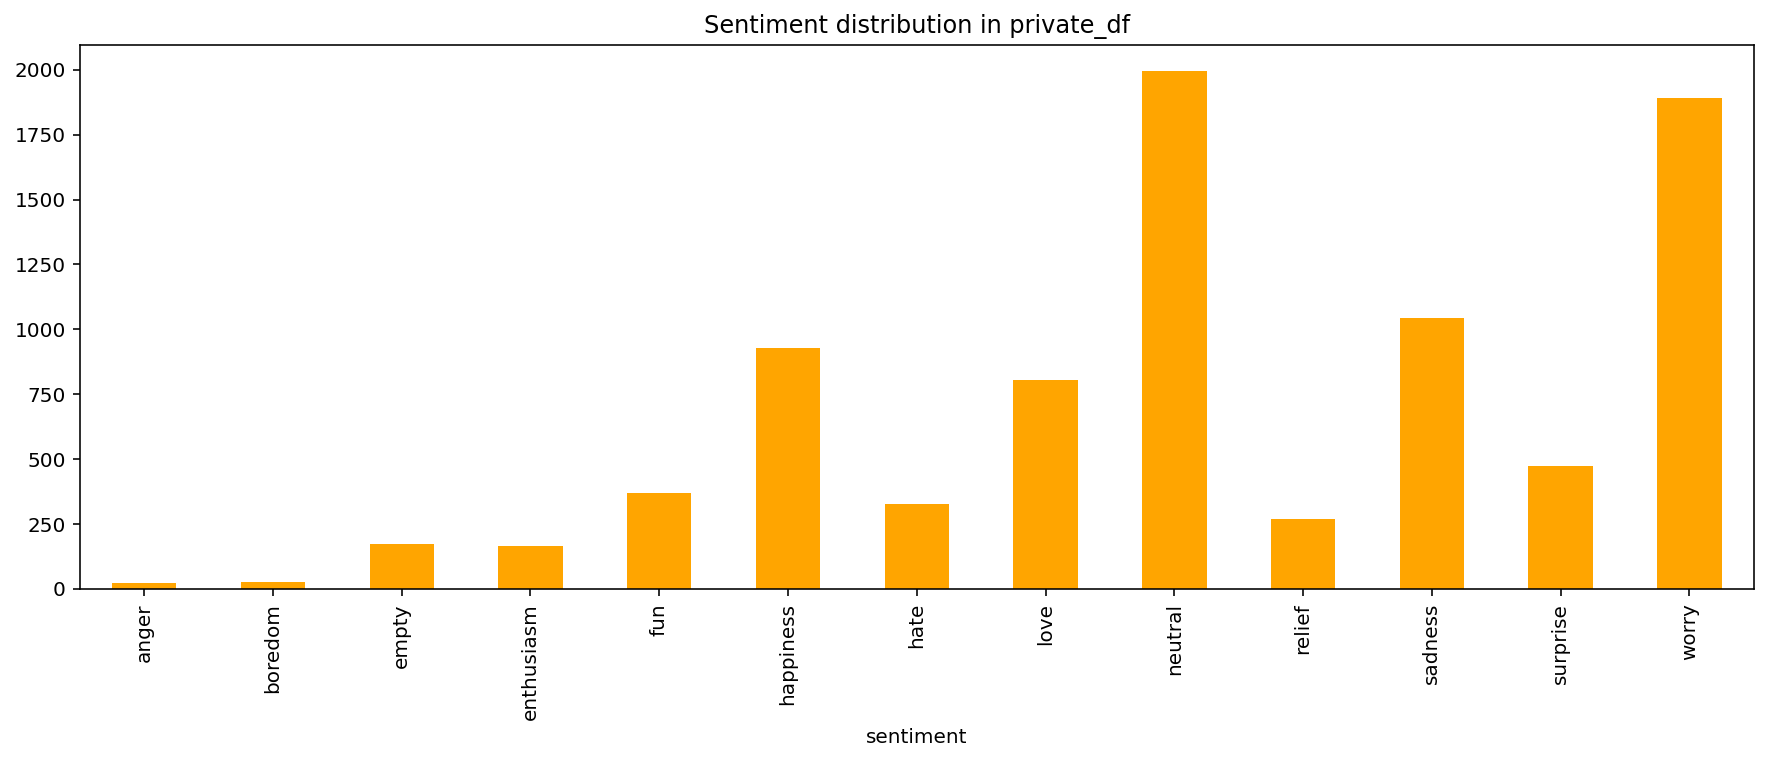

In [16]:
title = "Sentiment distribution in private_df"
private_df.groupby('sentiment')['content'].count().plot.bar(color='orange', title=title);

It seems that the `sentiment` distributions follows somehow the distribution of the entire dataset. Nice.

In [17]:
private_df['author'].value_counts()

PhotoAlert        8
erkagarcia        7
lesley007         5
ComcastBonnie     5
MiDesfileNegro    5
                 ..
CROOKLYNMAYO      1
jaffejuice        1
giselle6          1
tina5b5           1
megan_os          1
Name: author, Length: 8046, dtype: int64

We save the private_df in a CSV for further analysis! Now it's up to you ;)

In [18]:
private_df.to_csv("test_private_df.csv", index=False)

# Conclusions and next steps

There are much more that can be done, but some groundworks have been done. In the next days, I will investigate further the creation of the dataset, for instance by trying to map all tweets and try to construct a new model with the new features.

Please, let me know your opinions and share your advice on how to improve this notebook. I put a lot of effort into it and hope you appreciated.

Thank you for reading; I hope you learned something !! 🤗